In [1]:
import math
import numpy as np
import pandas as pd

import optuna
from optuna.integration import CatBoostPruningCallback

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from catboost import CatBoostClassifier
from catboost import Pool

from mlflow.models.signature import infer_signature
import mlflow

import itertools
from matplotlib import pyplot as plt

In [2]:
# NOTE: review the links mentioned above for guidance on connecting to a managed tracking server, such as the free Databricks Community Edition
mlflow.set_tracking_uri("http://193.109.79.28:8080")

In [3]:
data_test = pd.read_csv("test.csv")
data_train = pd.read_csv("train.csv")

In [4]:
data_train = data_train.drop('PassengerId', axis=1, inplace=False)
X = data_train.drop('Transported', axis=1)
y = data_train['Transported']

In [5]:
X

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre


In [6]:
# Разделение столбца 'Cabin' на три отдельных столбца
new_columns = X['Cabin'].str.split('/', expand=True)
new_columns.columns = ['Cabin_1', 'Cabin_2', 'Cabin_3']
# Объединение новых столбцов с исходным DataFrame
X = pd.concat([X, new_columns], axis=1)
X = X.drop('Cabin', axis=1)

# Разделение столбца 'Name' на три отдельных столбца
new_columns = X['Name'].str.split(' ', expand=True)
new_columns.columns = ['Name_1', 'Name_2']
# Объединение новых столбцов с исходным DataFrame
X = pd.concat([X, new_columns], axis=1)
X = X.drop('Name', axis=1)

In [7]:
# Сделаем тоже самое для data_test
new_columns1 = data_test['Cabin'].str.split('/', expand=True)
new_columns1.columns = ['Cabin_1', 'Cabin_2', 'Cabin_3']
data_test = pd.concat([data_test, new_columns1], axis=1)
data_test = data_test.drop('Cabin', axis=1)

# Сделаем тоже самое для data_test
new_columns1 = data_test['Name'].str.split(' ', expand=True)
new_columns1.columns = ['Name_1', 'Name_2']
data_test = pd.concat([data_test, new_columns1], axis=1)
data_test = data_test.drop('Name', axis=1)

In [8]:
X

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_1,Cabin_2,Cabin_3,Name_1,Name_2
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P,Maham,Ofracculy
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S,Juanna,Vines
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S,Altark,Susent
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S,Solam,Susent
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,98,P,Gravior,Noxnuther
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,G,1499,S,Kurta,Mondalley
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,1500,S,Fayey,Connon
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,608,S,Celeon,Hontichre


In [9]:
num_cols = ['Age','RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'Cabin_2','VRDeck', 'CryoSleep', 'VIP']
cat_cols = ['HomePlanet', 'Destination', 'Cabin_1', 'Cabin_3','Name_1','Name_2']
X[num_cols] = X[num_cols].astype(float)

In [10]:
#X[num_cols] = KNNImputer(n_neighbors = 50, weights = 'uniform').fit_transform(X[num_cols])
X[num_cols] = IterativeImputer(initial_strategy= 'most_frequent', n_nearest_features = 40, random_state=0, max_iter = 100).fit_transform(X[num_cols])
X[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[cat_cols])
X

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_1,Cabin_2,Cabin_3,Name_1,Name_2
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,B,0.0,P,Maham,Ofracculy
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,F,0.0,S,Juanna,Vines
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,A,0.0,S,Altark,Susent
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,A,0.0,S,Solam,Susent
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,F,1.0,S,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0.0,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,A,98.0,P,Gravior,Noxnuther
8689,Earth,1.0,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,G,1499.0,S,Kurta,Mondalley
8690,Earth,0.0,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,G,1500.0,S,Fayey,Connon
8691,Europa,0.0,55 Cancri e,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,E,608.0,S,Celeon,Hontichre


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   float64
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   float64
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Cabin_1       8693 non-null   object 
 11  Cabin_2       8693 non-null   float64
 12  Cabin_3       8693 non-null   object 
 13  Name_1        8693 non-null   object 
 14  Name_2        8693 non-null   object 
dtypes: float64(9), object(6)
memory usage: 1018.8+ KB


In [12]:
def outlier_function(df, col_name):
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
    
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
    
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count += 1
    return lower_limit, upper_limit, outlier_count

for col in  X[num_cols][:17]:
    out=outlier_function(X,col)
    if out[2]>0:
        print(f"There are {out[2]} outliers in {col}")
    else: print(f"There are not outliers in {col}")

There are not outliers in Age
There are 1682 outliers in RoomService
There are 1595 outliers in FoodCourt
There are 1523 outliers in ShoppingMall
There are 1512 outliers in Spa
There are not outliers in Cabin_2
There are 1576 outliers in VRDeck
There are not outliers in CryoSleep
There are 402 outliers in VIP


In [13]:
# Создаем пайплайн для числовых признаков: стандартизация + PCA
from sklearn.preprocessing import RobustScaler

numeric_transformer = Pipeline(steps=[
   ('scaler', RobustScaler()),
   #('PCA', PCA(#kernel='linear', n_components=9)) # разрежение признаков РСА
    #('LDA', LDA(n_components=1))  # разрежение признаков LDА
     ])

# Пайплайн для категориальных признаков: иммутация пропусков + кодирование
categorical_transformer = Pipeline(steps=[
   # ('encoder', OneHotEncoder(drop='first' , sparse_output=False, handle_unknown = 'infrequent_if_exist')),
    #('encoder', CatBoostEncoder()),
    #('encoder', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=10125)),
   # ('scaler', StandardScaler()),
 #   ('Imputer', SimpleImputer(strategy='most_frequent'))  # разрежение признаков РСА
    #('LDA', LDA(n_components=1))  # разрежение признаков LDА
    ])

# Создаем ColumnTransformer, который применяет нужные трансформации к числовым и категориальным признакам
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        #('cat', categorical_transformer, cat_cols),
         ], remainder = 'passthrough')

# Создание конвейера с препроцессором и классификатором
pipe = Pipeline(steps=[('preprocessor', preprocessor)]) 

In [14]:
# Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix11(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    font = {'size' : 15}

    plt.rc('font', **font)

    fig = plt.figure(figsize=(12, 8))
    plt.close(fig)

    return fig

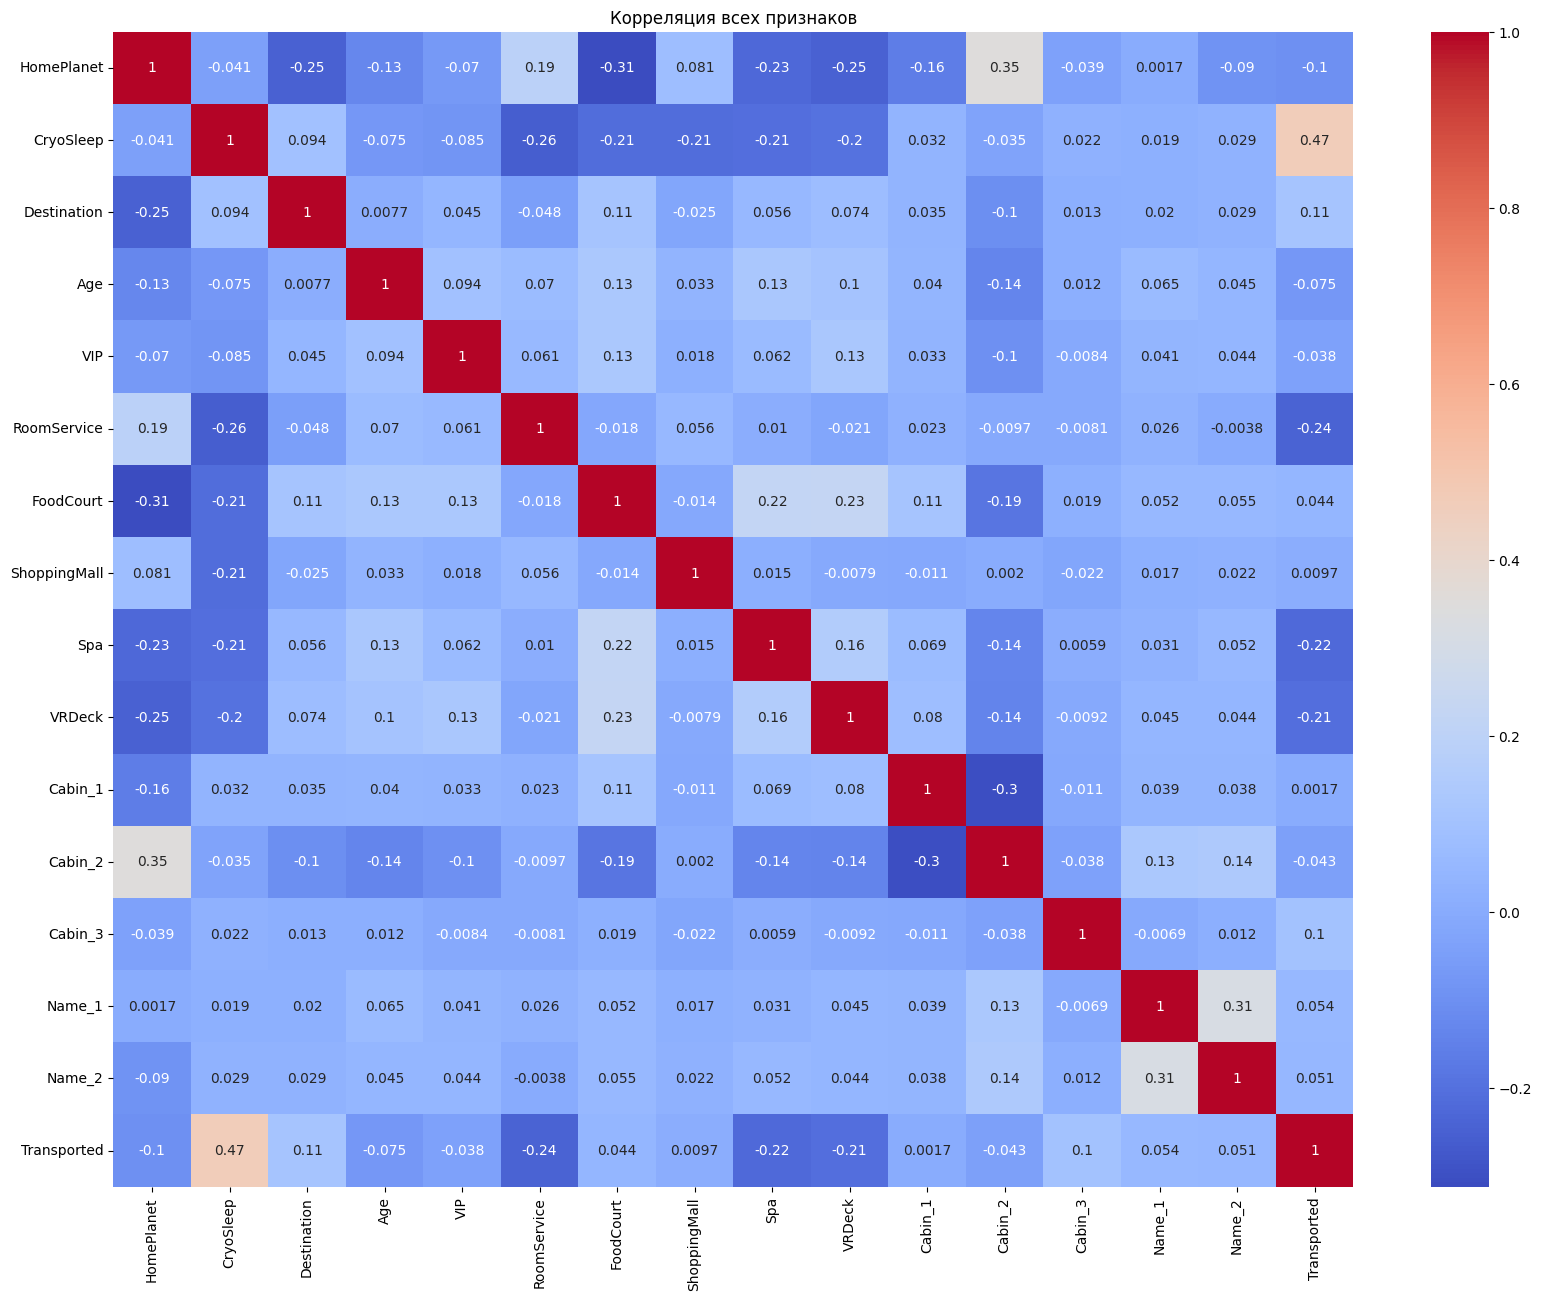

In [15]:
# Чтобы визуализировать корреляцию между всеми признаками (числовыми и категориальными),
# можно использовать heatmap.
# Для этого категориальные признаки нужно преобразовать в числовые.
# Преобразуем категориальные признаки в числовые
import seaborn as sns
df_encoded = pd.concat([X, y], axis=1)
df_encoded[cat_cols] = df_encoded[cat_cols].apply(lambda x: pd.factorize(x)[0])
# Вычисляем корреляцию
correlation_matrix = df_encoded.corr()
# Строим heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Корреляция всех признаков')
plt.show()

In [16]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Строит матрицу ошибок (confusion matrix).

    Args:
    - cm: Матрица ошибок (numpy array)
    - classes: Список классов (labels)
    - normalize: Нормализовать матрицу (True/False)
    - title: Заголовок графика
    - cmap: Цветовая схема

    Returns:
    - fig: Объект matplotlib.figure.Figure с графиком матрицы ошибок
    """
    fig, ax = plt.subplots(figsize=(12, 8))

    # Отображаем матрицу ошибок
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

    # Метки осей
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    # Нормализация матрицы ошибок
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Добавляем значения в ячейки матрицы
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], '.2f') if normalize else cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    # Настройка осей
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()

    return fig

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names=None):  # noqa: D417

    feature_importance = model.get_feature_importance()
    if feature_names is None:
        feature_names = model.feature_names_

    sorted_idx = np.argsort(feature_importance)
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels(np.array(feature_names)[sorted_idx])
    ax.set_xlabel('Feature Importance')
    ax.set_title('Feature Importance Plot')

    plt.tight_layout()
    return fig

In [18]:
def plot_learning_curve_AUC(model):  # noqa: D417
    """
    Строит кривую обучения (learning curve) для модели CatBoost на основе метрики AUC.
    Args:
    - model: Обученная модель CatBoost
    Returns:
    - fig: Объект matplotlib.figure.Figure с графиком кривой обучения
    """
    # Получаем метрики для обучающей и валидационной выборок
    train_metrics_AUC = model.get_evals_result()['learn']['AUC']
    eval_metrics_AUC = model.get_evals_result()['validation']['AUC']

    # Строим кривую обучения
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train_metrics_AUC, label='Train AUC')
    ax.plot(eval_metrics_AUC, label='Validation AUC')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('AUC')
    ax.set_title('Learning Curve (AUC)')
    ax.legend()
    plt.tight_layout()

    return fig

In [19]:
import matplotlib.pyplot as plt

def plot_learning_curve_Logloss(model):  # noqa: D417
    """
    Строит кривую обучения (learning curve) для модели CatBoost на основе метрики AUC.
    Args:
    - model: Обученная модель CatBoost
    Returns:
    - fig: Объект matplotlib.figure.Figure с графиком кривой обучения
    """
    # Получаем метрики для обучающей и валидационной выборок
    train_metrics_Logloss = model.get_evals_result()['learn']['Logloss']
    eval_metrics_Logloss = model.get_evals_result()['validation']['Logloss']

    # Строим кривую обучения
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train_metrics_Logloss, label='Train Logloss')
    ax.plot(eval_metrics_Logloss, label='Validation Logloss')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Logloss')
    ax.set_title('Learning Curve (Logloss)')
    ax.legend()
    plt.tight_layout()

    return fig

In [20]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)

In [21]:
experiment_id = get_or_create_experiment("Optuna Hyperparameter Tuning Space Titanic Transported")
experiment_id

'105780219601328801'

In [22]:
# Set the current active MLflow experiment

# Придется убрать!!!!!
mlflow.set_experiment(experiment_id=experiment_id)
# Разделение данных на обучающий и тестовый наборы
rng = np.random.RandomState(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, 
                     stratify=y, random_state=rng)

# Применяем робастную стандартизацию к числовым признакам
scaler = RobustScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train[num_cols])
X_test_numeric_scaled = scaler.transform(X_test[num_cols])

# Преобразуем результаты обратно в DataFrame
X_train_numeric_scaled = pd.DataFrame(X_train_numeric_scaled, columns=num_cols, index=X_train.index)
X_test_numeric_scaled = pd.DataFrame(X_test_numeric_scaled, columns=num_cols, index=X_test.index)

# Объединяем числовые и категориальные признаки
X_train_scaled = pd.concat([X_train_numeric_scaled, X_train[cat_cols]], axis=1,ignore_index=True)
X_test_scaled = pd.concat([X_test_numeric_scaled, X_test[cat_cols]], axis=1, ignore_index=True)

train_pool = Pool(X_train_scaled, y_train, cat_features=[9,10,11,12,13,14])#, feature_names=X_train.columns.tolist())
test_pool = Pool(X_test_scaled, y_test, cat_features=[9,10,11,12,13,14])#, feature_names=X_test.columns.tolist())


In [23]:
X_train_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
3588,-0.352941,41.046875,0.000000,15.710526,0.000000,-0.235075,0.000000,0.0,0.0,Mars,TRAPPIST-1e,E,S,Blakes,Ple
709,-0.470588,0.000000,0.000000,0.000000,0.000000,-0.414179,0.000000,1.0,0.0,Earth,TRAPPIST-1e,G,S,Milyla,Waltonnedy
2125,-0.529412,0.000000,0.000000,4.334538,0.000000,-0.453980,0.000000,1.0,0.0,Europa,55 Cancri e,C,P,Gemmam,Crantiale
3108,-0.823529,0.000000,0.000000,0.000000,0.000000,-0.398010,0.000000,1.0,0.0,Europa,55 Cancri e,C,S,Bellah,Reming
5018,-0.529412,0.000000,3.398868,0.000000,2.209416,0.815920,0.000000,0.0,0.0,Earth,PSO J318.5-22,F,P,Elica,Brantuarez
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,-0.058824,2.562500,0.000000,22.447368,0.000000,-0.344527,0.629032,0.0,0.0,Mars,TRAPPIST-1e,D,P,Money,Sache
4406,0.647059,2.859375,2.103627,0.000000,1.620239,0.629353,6.032258,0.0,0.0,Earth,TRAPPIST-1e,F,P,Sonnie,Mcleaney
8485,-0.117647,0.000000,0.000000,0.000000,0.000000,0.261008,0.000000,1.0,0.0,Europa,55 Cancri e,F,S,Bath,Brakeng
5344,0.882353,0.000000,0.300518,8.342105,6.392578,0.584577,0.725806,0.0,0.0,Earth,TRAPPIST-1e,G,P,Lawren,Blangibson


In [ ]:
# Set the current active MLflow experiment

mlflow.set_experiment(experiment_id=experiment_id)
# Разделение данных на обучающий и тестовый наборы
rng = np.random.RandomState(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, 
                     stratify=y, random_state=rng)

# Применяем робастную стандартизацию к числовым признакам
X_train_scaled = pipe.fit_transform(X_train)
X_test_scaled = pipe.transform(X_test)
# Преобразуем результаты обратно в DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index)


train_pool = Pool(X_train_scaled, y_train, cat_features=cat_cols, feature_names=X_train.columns.tolist())
test_pool = Pool(X_test_scaled, y_test, cat_features=cat_cols, feature_names=X_test.columns.tolist())

In [78]:
def objective(trial):
    with mlflow.start_run(run_name='Дочерний запуск', #parent_run_id=experiment_id, 
                          nested=True):
        # Define hyperparameters
        params = {
            'iterations': trial.suggest_int("iterations", 1000, 3000),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.9),
            "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 3, 50),
            "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
            "depth": trial.suggest_int("depth", 3, 16),
            "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
            "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
            "rsm": trial.suggest_float("rsm", 0.5, 0.55),
            "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),
            "max_ctr_complexity": trial.suggest_int("max_ctr_complexity", 1, 2),
            "eval_metric": "AUC",
            "loss_function": 'Logloss',
            'leaf_estimation_method': 'Newton'
            }

        if params["bootstrap_type"] == "Bayesian":
            params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)
        elif params["bootstrap_type"] == "Bernoulli":
            params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

        # Train CatBoost model
        model = CatBoostClassifier(**params)
        pruning_callback = CatBoostPruningCallback(trial, "AUC")
        model.fit(train_pool, eval_set=test_pool, callbacks=[pruning_callback], early_stopping_rounds=100, 
                  use_best_model=True, verbose=500)
        # evoke pruning manually
        pruning_callback.check_pruned()

        preds = model.predict(test_pool)
        accuracy = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        ROC_AUC = roc_auc_score(y_test, preds)

        # Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("ROC_AUC", ROC_AUC)
        
        # Log the model to MLflow
        signature = infer_signature(X_test, preds)
        mlflow.catboost.log_model(model, "model",
                              #signature=signature, input_example=X_test[:10],
                              #model_format="ubj", metadata={"model_data_version": 1},
                              )

    return ROC_AUC #accuracy#, precision, recall, f1, ROC_AUC, preds

In [25]:
#Название родительского запуска
run_name = "14_attempt optuna.pruners.SuccessiveHalvingPruner"

[I 2024-12-25 07:24:44,264] Using an existing study with name 'hyperparameter_tuning_study' instead of creating a new one.
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_5944\718566659.py:28: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "AUC")


0:	test: 0.8074283	best: 0.8074283 (0)	total: 149ms	remaining: 4m 46s


[I 2024-12-25 07:24:45,920] Trial 15 pruned. Trial was pruned at iteration 5.



bestTest = 0.8813772722
bestIteration = 5

Shrink model to first 6 iterations.
🏃 View run Дочерний запуск at: http://193.109.79.28:8080/#/experiments/105780219601328801/runs/80a5c472f9754224835e6b8c07357a31
🧪 View experiment at: http://193.109.79.28:8080/#/experiments/105780219601328801
0:	test: 0.8132360	best: 0.8132360 (0)	total: 49.1ms	remaining: 1m 6s


[I 2024-12-25 07:24:47,061] Trial 16 pruned. Trial was pruned at iteration 5.



bestTest = 0.8808358672
bestIteration = 5

Shrink model to first 6 iterations.
🏃 View run Дочерний запуск at: http://193.109.79.28:8080/#/experiments/105780219601328801/runs/f63df88e3e9f490a8dbefd5685327f7c
🧪 View experiment at: http://193.109.79.28:8080/#/experiments/105780219601328801
0:	test: 0.8235364	best: 0.8235364 (0)	total: 42.4ms	remaining: 1m 27s


[I 2024-12-25 07:24:48,170] Trial 17 pruned. Trial was pruned at iteration 5.



bestTest = 0.8573624095
bestIteration = 5

Shrink model to first 6 iterations.
🏃 View run Дочерний запуск at: http://193.109.79.28:8080/#/experiments/105780219601328801/runs/76766068c1584543ab0582f56d62b057
🧪 View experiment at: http://193.109.79.28:8080/#/experiments/105780219601328801


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6668571	test: 0.6669852	best: 0.6669852 (0)	total: 61ms	remaining: 2m 21s
500:	learn: 0.3424432	test: 0.3849771	best: 0.3848716 (426)	total: 21.6s	remaining: 1m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3845823069
bestIteration = 615

Shrink model to first 616 iterations.
Confusion matrix, without normalization
[[1114  267]
 [ 274 1127]]
🏃 View run 13_attempt optuna.pruners.SuccessiveHalvingPruner at: http://193.109.79.28:8080/#/experiments/105780219601328801/runs/fecc5f29eb884f35bdcccff802bc78b4
🧪 View experiment at: http://193.109.79.28:8080/#/experiments/105780219601328801


KeyboardInterrupt: 

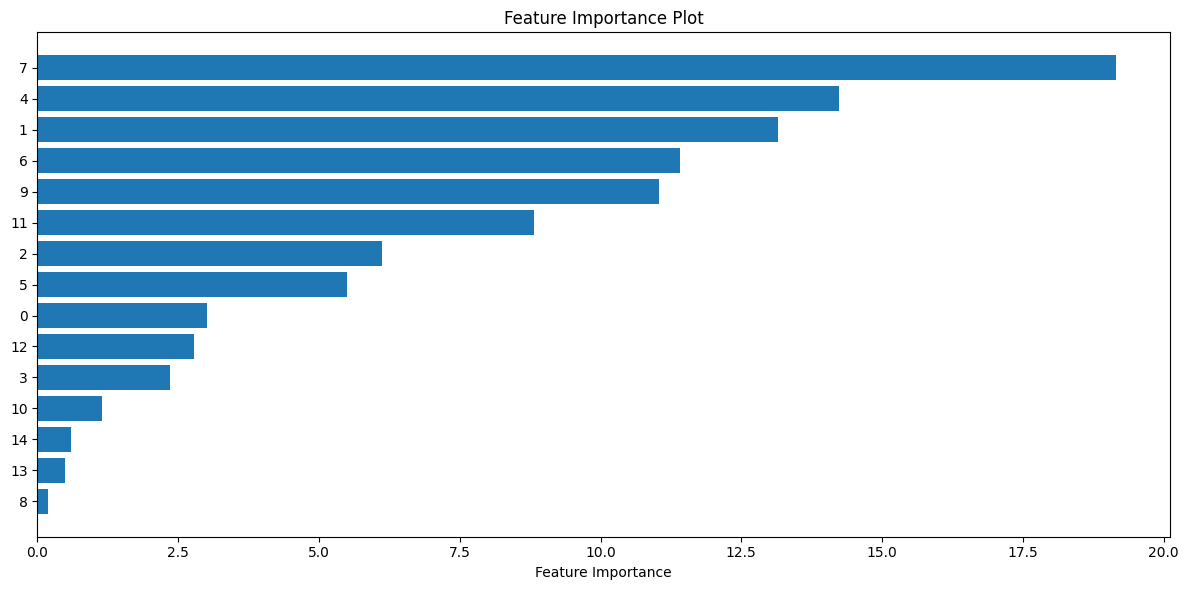

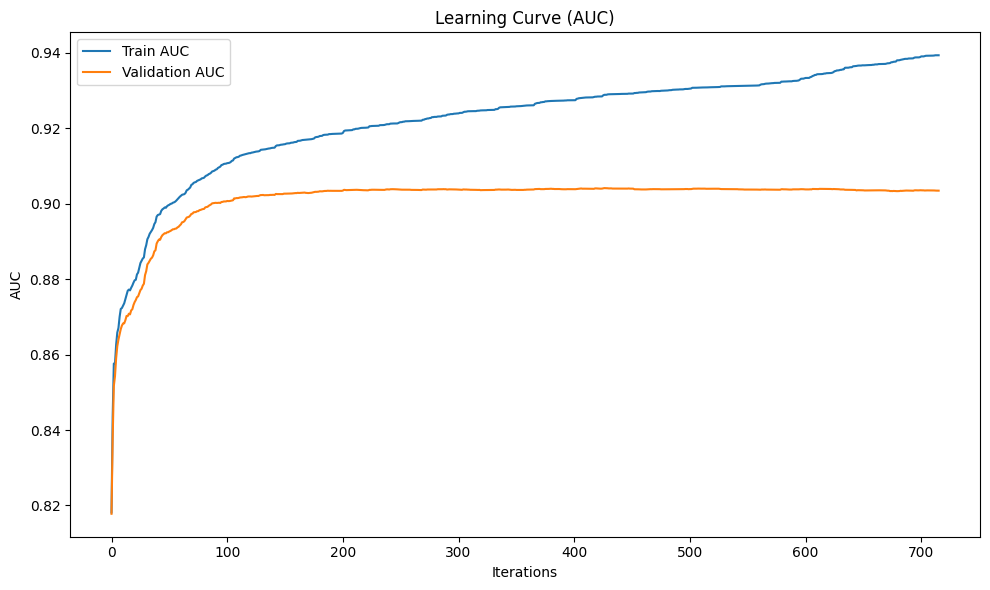

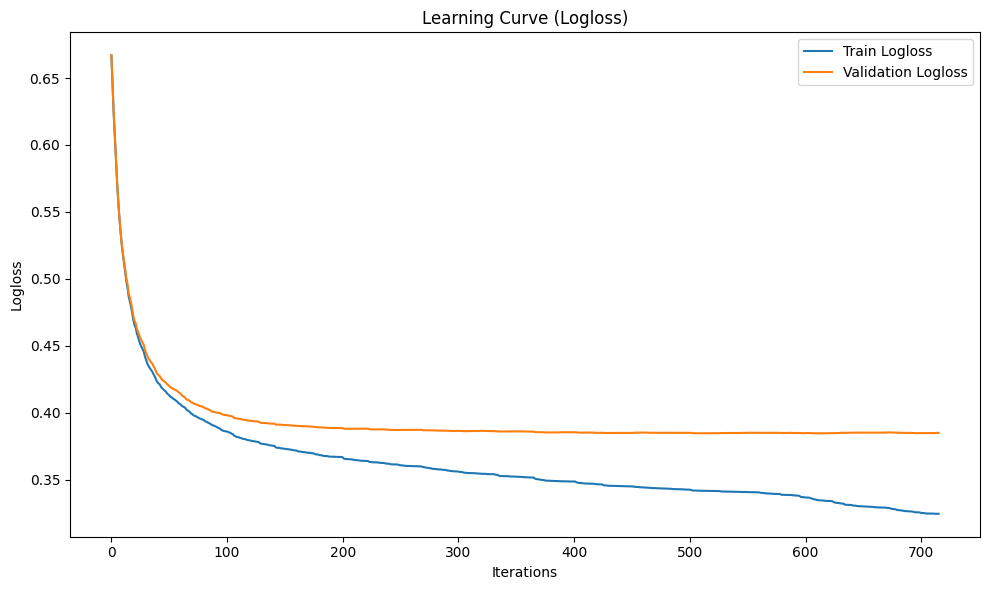

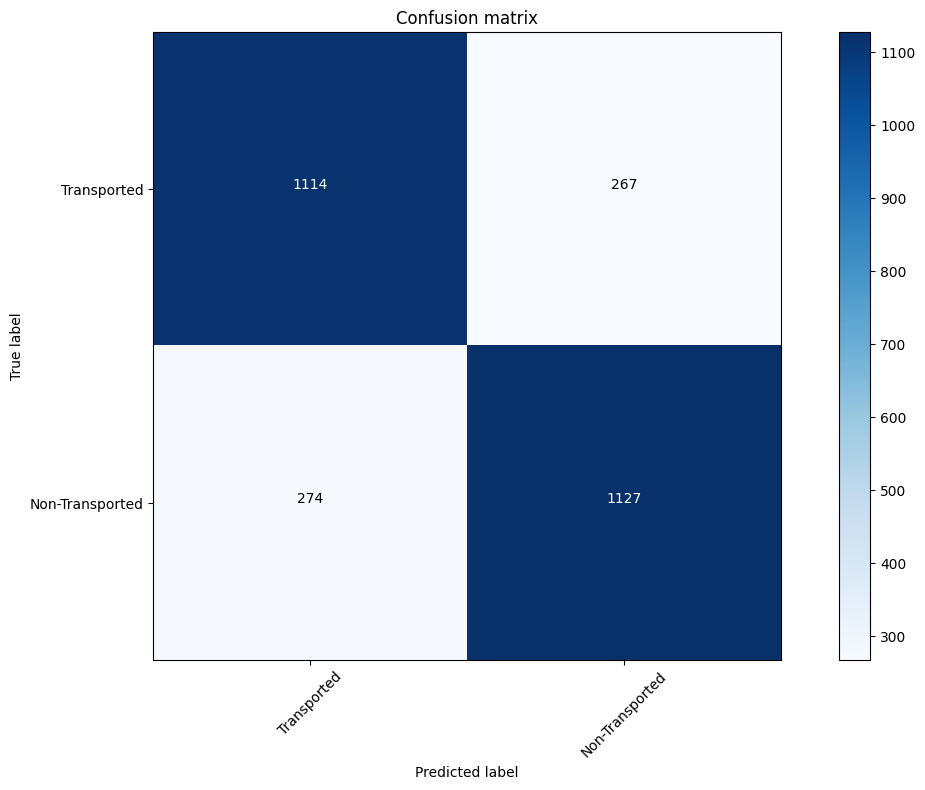

In [79]:
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Initialize the Optuna study

    # Настройка Optuna
    study_name = "hyperparameter_tuning_study"
    storage_path = "sqlite:///optuna_study.db"  # SQLite для хранения Study
    
    study = optuna.create_study(
    study_name=study_name,
    storage=storage_path,
    load_if_exists=True,  # Загрузить существующий Study, если он есть
    direction="maximize",
    pruner=optuna.pruners.SuccessiveHalvingPruner()
     )
    #study = optuna.create_study(direction="maximize", pruner=optuna.pruners.SuccessiveHalvingPruner())

    # Execute the hyperparameter optimization trials.
    study.optimize(objective, n_trials=3, #timeout=3600
                   )
    
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_ROC_AUC", study.best_value)
    
    # Log tags
    mlflow.set_tags(
        tags={
            "project": "SpaceTitanic Transported Project",
            "optimizer_engine": "optuna",
            'pruner': 'optuna.pruners.SuccessiveHalvingPruner',
            'pruning_callback': 'YES',
            'early_stopping_rounds':'100',
            'objective_n_trials':100,
            "model_family": "Catboost",
            "feature_set_version": 1,
            "host": "ASUS"
        })

    # Train the final model with the best parameters
    final_model = CatBoostClassifier(**study.best_params, custom_metric=[
        'AUC:hints=skip_train~false',  # Включить расчет AUC на обучающей выборке
        'Logloss:hints=skip_train~true'  # Отключить расчет Logloss на обучающей выборке
    ],)
    
    final_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100, 
                                       plot=True, use_best_model=True, verbose=500)
   
    # Log the correlation plot
    #mlflow.log_figure(figure=correlation_matrix, artifact_file="correlation_plot.png")

    # Log the feature importances plot
    importances = plot_feature_importance(final_model)
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")

    # Log кривой обучения по метрике ROC_AUC
    learning_curve_AUC = plot_learning_curve_AUC(final_model)
    mlflow.log_figure(figure=learning_curve_AUC, artifact_file="learning_curve_AUC.png")

    # Log кривой обучения по метрике Logloss
    learning_curve_Logloss = plot_learning_curve_Logloss(final_model)
    mlflow.log_figure(figure=learning_curve_Logloss, artifact_file="learning_curve_Logloss.png")

    # Log the confusion matrix plot
    preds = final_model.predict(test_pool)
    cnf_matrix = confusion_matrix(y_test, preds)
    conf_matrix = plot_confusion_matrix(cnf_matrix, classes=['Transported', 'Non-Transported'],
                      title='Confusion matrix')
    mlflow.log_figure(figure=conf_matrix, artifact_file="Confusion matrix.png")

    artifact_path = "final_model"
    signature = infer_signature(X_test, preds)
    mlflow.catboost.log_model(final_model, "final_model", 
                             # signature=signature, input_example=X_test[:10],
                              )
    preds = final_model.predict(test_pool)
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    ROC_AUC = roc_auc_score(y_test, preds)

    print(f'Accuracy = { accuracy:.6f}')
    print(f'Precision: {precision:.6f}')
    print(f'Recall: {recall:.6f}')
    print(f'F1 = {f1:.6f}')
    print(f'ROC_AUC_SCORE = {ROC_AUC:.6f}')

    # Log to MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("ROC_AUC", ROC_AUC)

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)

In [ ]:
study.best_value

In [34]:
study.best_params

{'iterations': 2328,
 'learning_rate': 0.06846842854190985,
 'l2_leaf_reg': 6,
 'auto_class_weights': 'SqrtBalanced',
 'depth': 5,
 'bootstrap_type': 'MVS',
 'grow_policy': 'Lossguide',
 'rsm': 0.503879939991907,
 'leaf_estimation_iterations': 2,
 'max_ctr_complexity': 1}

In [38]:
preds = final_model.predict(test_pool)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
ROC_AUC = roc_auc_score(y_test, preds)

print(f'Accuracy = { accuracy:.6f}')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')
print(f'F1 = {f1:.6f}')
print(f'ROC_AUC_SCORE = {ROC_AUC:.6f}')

Accuracy = 0.805536
Precision: 0.808465
Recall: 0.804425
F1 = 0.806440
ROC_AUC_SCORE = 0.805544


In [40]:
model = mlflow.pyfunc.load_model("runs:/ce15b301fab2415da412b27bf5a185da/final_model")

In [41]:
loaded = mlflow.catboost.load_model(model_uri)

In [42]:
# Сохранение модели в .pkl
import joblib
joblib.dump(loaded, 'catboost_model.pkl')

['catboost_model.pkl']

In [47]:
data_test[num_cols] = IterativeImputer(initial_strategy= 'most_frequent', n_nearest_features = 100, random_state=0, max_iter = 100).fit_transform(data_test[num_cols])
data_test[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(data_test[cat_cols])
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4277 non-null   object 
 2   CryoSleep     4277 non-null   float64
 3   Destination   4277 non-null   object 
 4   Age           4277 non-null   float64
 5   VIP           4277 non-null   float64
 6   RoomService   4277 non-null   float64
 7   FoodCourt     4277 non-null   float64
 8   ShoppingMall  4277 non-null   float64
 9   Spa           4277 non-null   float64
 10  VRDeck        4277 non-null   float64
 11  Cabin_1       4277 non-null   object 
 12  Cabin_2       4277 non-null   float64
 13  Cabin_3       4277 non-null   object 
 14  Name_1        4277 non-null   object 
 15  Name_2        4277 non-null   object 
dtypes: float64(9), object(7)
memory usage: 534.8+ KB


In [48]:
# Применяем робастную стандартизацию к числовым признакам
scaler = RobustScaler()
data_test_numeric_scaled = scaler.fit_transform(data_test[num_cols])
# Преобразуем результаты обратно в DataFrame
data_test_numeric_scaled = pd.DataFrame( data_test_numeric_scaled, columns=num_cols, index=data_test.index)
# Объединяем числовые и категориальные признаки
data_test_scaled = pd.concat([data_test_numeric_scaled, data_test[cat_cols]], axis=1, ignore_index=True)
data_test_scaled


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.058824,0.000000,0.000000,0.000000,0.000000,-0.548619,0.00,1.0,0.0,Earth,TRAPPIST-1e,G,S,Nelly,Carsoning
1,-0.411765,0.000000,0.068702,0.000000,34.972596,-0.547419,0.00,0.0,0.0,Earth,TRAPPIST-1e,F,S,Lerome,Peckers
2,0.294118,0.000000,0.000000,0.000000,0.000000,-0.552221,0.00,1.0,0.0,Europa,55 Cancri e,C,S,Sabih,Unhearfus
3,0.705882,0.000000,50.778626,0.000000,2.242310,-0.551020,11.70,0.0,0.0,Europa,TRAPPIST-1e,C,S,Meratz,Caltilter
4,-0.352941,0.126582,0.000000,12.450980,0.000000,-0.546218,0.00,0.0,0.0,Earth,TRAPPIST-1e,F,S,Brence,Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.470588,0.000000,0.000000,0.000000,0.000000,1.243697,0.00,1.0,0.0,Earth,TRAPPIST-1e,G,S,Jeron,Peter
4273,0.941176,0.000000,6.465649,0.333333,0.123885,0.122781,2.88,0.0,0.0,Earth,TRAPPIST-1e,F,S,Matty,Scheron
4274,0.147268,0.000000,0.000000,0.000000,0.000000,-0.196879,0.00,1.0,0.0,Mars,55 Cancri e,D,P,Jayrin,Pore
4275,0.251349,0.000000,20.458015,0.000000,0.000000,-0.195678,10.46,0.0,0.0,Europa,TRAPPIST-1e,D,P,Kitakan,Conale


In [49]:
data_test_pool = Pool(data_test_scaled, cat_features=[9,10,11,12,13,14])
predictions = loaded.predict(data_test_pool)
submission_ids = data_test['PassengerId']
predictions = pd.Series(predictions).astype(bool)
predictions = pd.DataFrame({'Transported': predictions.astype(bool)})
sample_submission = pd.concat([submission_ids, predictions],axis=1)
sample_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [50]:
# Запись DataFrame в файл CSV
sample_submission.to_csv('sample_submission.csv', index=False)